# Лабораторная работа №7

|Выполнил студент группы|ФИО|Вариант|
|--|--|--|
|М8О-406Б-19|Илья Ильин Олегович|1|

### Задание

Решить краевую задачу для дифференциального уравнения эллиптического типа.
Аппроксимацию уравнения произвести с использованием центрально-разностной
схемы. Для решения дискретного аналога применить следующие методы: метод
простых итераций (метод Либмана), метод Зейделя, метод простых итераций с
верхней релаксацией. 

Вычислить
погрешность численного решения путем сравнения результатов с приведенным в
задании аналитическим решением
$U(x,t)$
. Исследовать зависимость погрешности от
сеточных параметров
$ h_x, h_y$ .

### Вариант

$\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = 0$

$u_x(0, y) = 0$

$u(1, y) = 1 - y^2$

$u_y(x, 0) = 0$

$u(x,1) = x^2 - 1$

Аналитическое решение: 
$U(x,y) = x^2 - y^2$


In [6]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Callable
from functools import partial

import copy

In [7]:
def init_u(x: np.ndarray, y: np.ndarray,
           u_x_initial_1: Callable, u_y_initial_1: Callable,
           l: float, r: float) -> np.ndarray:
    u: np.ndarray = np.zeros(shape=(len(y), len(x)))
    u[:, -1] = u_y_initial_1(y)
    u[-1, :] = u_x_initial_1(x)
    for j in range(len(x) - 2, -1, -1):
        for i in range(len(y) - 2, -1, -1):
            u[i, j] = u[i + 1, j] * x[j] / (x[j] + y[i] + 0.0001)
            u[i, j] += u[i, j + 1] * y[i] / (x[j] + y[i] + 0.0001)
    return u

'''
Есть значения, из предыдущих берем новый считаем, используя значения из пред операций
'''
def simple_iter_method(u_y_initial_0_dx: Callable, u_y_initial_1: Callable,
                       u_x_initial_0_dy: Callable, u_x_initial_1: Callable,
                       h: float, l: float, r: float) -> np.ndarray:
    x: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    y: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    u: np.ndarray = init_u(x, y, u_x_initial_1, u_y_initial_1, l, r)

    eps: float = 3e-5
    prev: np.ndarray = np.zeros(shape=(len(y), len(x)))
    curr_iter: int = 0
    max_iter: int = 2000
    diff: float = np.abs(u - prev).max()
    diverge_coef: float = 1.5
    while diff > eps and curr_iter <= max_iter:
        prev_diff: float = diff
        prev = copy.deepcopy(u)

        u[0, :-1] = (-2.0 * h * u_x_initial_0_dy(x[:-1]) + 4.0 * prev[1, :-1] - prev[2, :-1]) / 3.0
        u[:-1, 0] = (-2.0 * h * u_y_initial_0_dx(y[:-1]) + 4.0 * prev[:-1, 1] - prev[:-1, 2]) / 3.0
        for i in range(1, len(y) - 1):
            for j in range(1, len(x) - 1):
                u[i, j] = (prev[i-1, j] + prev[i+1, j] + prev[i, j-1] + prev[i, j+1]) / 4.0

        diff = np.abs(u - prev).max()
        curr_iter += 1
        if diff > diverge_coef * prev_diff:
            print("WARNING : Max_iter starts diverge on iter = %s", curr_iter)
            break

    if curr_iter >= max_iter:
        print("WARNING : Max_iter was reached")

    print("INFO : iters count = %s", curr_iter)

    return u

'''
Если мы поссчитали значения в этой итерации, то можем их использовать в ней же (2 из нынешней, 2 из прошлой)
'''
def relaxation_iter_method(u_y_initial_0_dx: Callable, u_y_initial_1: Callable,
                           u_x_initial_0_dy: Callable, u_x_initial_1: Callable,
                           h: float, l: float, r: float,
                           w: float) -> np.ndarray:
    x: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    y: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    u: np.ndarray = init_u(x, y, u_x_initial_1, u_y_initial_1, l, r)

    eps: float = 3e-5
    prev: np.ndarray = np.zeros(shape=(len(y), len(x)))
    curr_iter: int = 0
    max_iter: int = 2000
    diff: float = np.abs(u - prev).max()
    diverge_coef: float = 1.5
    while diff > eps and curr_iter <= max_iter:
        prev_diff: float = diff
        prev = copy.deepcopy(u)

        u[0, :-1] += w * ((-2.0 * h * u_x_initial_0_dy(x[:-1]) + 4.0 * u[1, :-1] - u[2, :-1]) / 3.0 - u[0, :-1])
        u[:-1, 0] += w * ((-2.0 * h * u_y_initial_0_dx(y[:-1]) + 4.0 * u[:-1, 1] - u[:-1, 2]) / 3.0 - u[:-1, 0])
        for i in range(1, len(y) - 1):
            for j in range(1, len(x) - 1):
                u[i, j] += w * ((u[i-1, j] + prev[i+1, j] + u[i, j-1] + prev[i, j+1]) / 4.0 - prev[i, j])

        diff = np.abs(u - prev).max()
        curr_iter += 1
        if diff > diverge_coef * prev_diff:
            print("WARNING : Max_iter starts diverge on iter = %s", curr_iter)
            break

    if curr_iter >= max_iter:
        print("WARNING : Max_iter was reached")

    print("INFO : iters count = %s", curr_iter)

    return u


seidel_method = partial(relaxation_iter_method, w=1.0)

In [14]:
def analytical_solution(x: float, y: float) -> float:
    return x**2 - y**2


def analytical_grid(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    grid: np.ndarray = np.zeros(shape=(len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            grid[i, j] = analytical_solution(x[j], y[i])
    return grid


def u_y_initial_0_dx(y: np.ndarray) -> np.ndarray:
    return np.zeros(len(y))


def u_y_initial_1(y: np.ndarray) -> np.ndarray:
    return 1.0 - y**2


def u_x_initial_0_dy(x: np.ndarray) -> np.ndarray:
    return np.zeros(len(x))


def u_x_initial_1(x: np.ndarray) -> np.ndarray:
    return x**2 - 1.0


def error(numeric: np.ndarray, analytical: np.ndarray, axis: int) -> np.ndarray:
    return np.max(np.abs(numeric - analytical), axis=axis)


def draw_error(numeric, analytical, x, y):
    fig = plt.figure(figsize=plt.figaspect(0.35))
    plt.title('Error')

    # ax = fig.add_subplot(1, 3, 1)
    # err = error(numeric=numeric, analytical=analytical, axis=1)
    # ax.plot(np.arange(0, err.shape[0]), err)
    # # ax.set_xlabel('x')
    # ax.set_ylabel('error') 

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(y, [np.max(np.abs(numeric-analytical)[:,i]) for i in range(len(y))])
    ax.set_ylabel('error')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(y, [np.max(np.abs(numeric-analytical)[i,:]) for i in range(len(x))])
    ax.set_ylabel('error')


# def draw_yerror(numeric, analytical):
#     # print(numeric.shape)
#     err = error(numeric=numeric, analytical=analytical, axis=0)
#     # print(err.shape)
#     # print(np.arange(0, err.shape[0]).shape)
#     plt.plot(np.arange(0, err.shape[0]), err)
#     plt.title('Error on Y axis')
#     plt.xlabel('x')
#     plt.ylabel('error')
#     plt.show()


def draw(numerical: np.ndarray, analytical: np.ndarray,
         x: np.ndarray, y: np.ndarray,
         title_lhs: str, title_rhs: str):
    fig = plt.figure(figsize=plt.figaspect(0.7))
    xx, yy = np.meshgrid(x, y)

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plt.title(title_lhs)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    ax.set_zlabel('u', fontsize=20)
    ax.plot_surface(xx, yy, numerical, cmap=cm.coolwarm, linewidth=0, antialiased=True)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    ax.set_zlabel('u', fontsize=20)
    plt.title(title_rhs)
    ax.plot_surface(xx, yy, analytical, cmap=cm.coolwarm, linewidth=0, antialiased=True)

    plt.show()
    # print(numerical.shape, analytical.shape)
    draw_error(numerical, analytical, xx, yy)

In [15]:
def runner(h):
    x: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)
    y: np.ndarray = np.arange(0, 1.0 + h/2.0, step=h)

    kwargs = {
        "u_y_initial_0_dx": u_y_initial_0_dx,
        "u_y_initial_1": u_y_initial_1,
        "u_x_initial_0_dy": u_x_initial_0_dy,
        "u_x_initial_1": u_x_initial_1,
        "h": h,
        "l": 0.0,
        "r": 1.0
    }

    analytical = analytical_grid(x, y)

    print("---------------- SIMPLE ITER ----------------")
    sol = simple_iter_method(**kwargs)
    # print(np.round(sol, 2))
    # print("\nError: ", error(sol, analytical))
    # print("---------------------------------------------")
    # print("--------------- ANALYTICAL ------------------")
    # print(np.round(analytical, 2))
    draw(sol, analytical, x, y, 'simple iter', 'analytic')
    # draw_error(sol, analytical)

    print("\n\n---------------- SEIDEL ----------------")
    sol = seidel_method(**kwargs)
    # print(np.round(sol, 2))
    # print("\nError: ", error(sol, analytical))
    # print("-----------------------------------------")
    # print("-------------- ANALYTICAL ---------------")
    # print(np.round(analytical, 2))
    draw(sol, analytical, x, y, 'seidel', 'analytic')
    # draw_error(sol, analytical)

    print("\n\n---------------- RELAXATION ITER ----------------")
    sol = relaxation_iter_method(**kwargs, w=1.5)
    # print(np.round(sol, 2))
    # print("\nError: ", error(sol, analytical))
    # print("-------------------------------------------------")
    # print("------------------ ANALYTICAL -------------------")
    # print(np.round(analytical, 2))
    draw(sol, analytical, x, y, 'relaxation iter', 'analytic')



---------------- SIMPLE ITER ----------------
INFO : iters count = %s 58


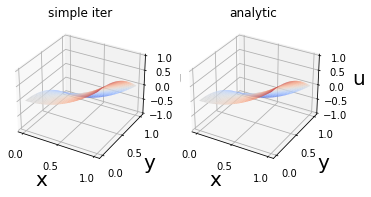



---------------- SEIDEL ----------------
INFO : iters count = %s 44


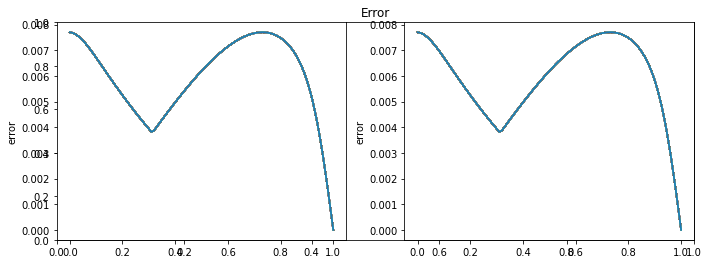

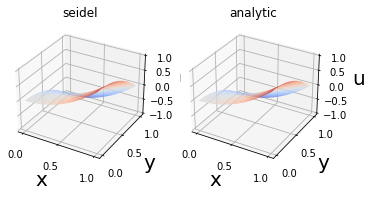



---------------- RELAXATION ITER ----------------
INFO : iters count = %s 74


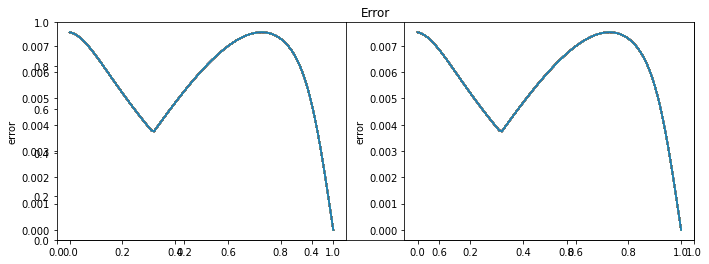

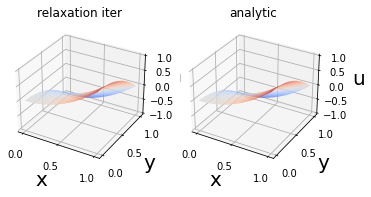

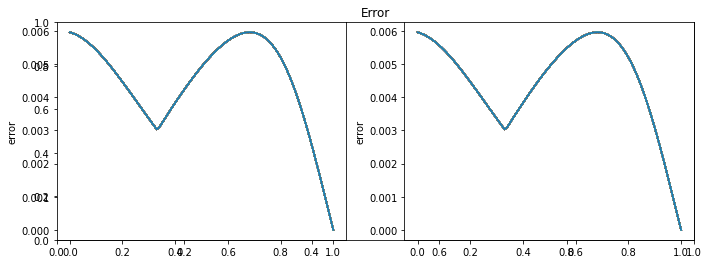

In [16]:
runner(0.01)
# 2 графика ошибки, по каждой оси